In [111]:
#libs
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

#regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
## load data
df = pd.read_csv('../data/trees_data_train.csv', index_col=0)
#load pcs
tree_pcs = pd.read_csv('../data/single_tree_pcs.csv', index_col=0)
xval_zones = pd.read_csv('../data/Zone_splits_OFFICIAL.txt')

df.HEIGHT = pd.to_numeric(df.HEIGHT, errors='coerce')
df.DBH = pd.to_numeric(df.DBH, errors='coerce')

In [135]:
#Label taxa categories
conifer_fams = ['Pinaceae', 'Arucarailes', 'Podocarpaceae', 'Sciadopityaceae', 'Cupressaceae', 'Cephalotaxaceae', 'Taxaceae']
genus_codes = {'PINUS':1, 'ACER':2, 'QUERCUS':3, 'MALUS':4, 'GLEDITSIA': 5, 
               'PICEA': 6, 'ULMUS': 7, 'THUJA': 8, 'PLATANUS': 9, 'FRAXINUS': 10}
df['CONIFER_CAT'] = df.FAMILY.isin(conifer_fams).map({True: 1, False: 2})
df['GENUS_CAT'] = df.GENUS.map(genus_codes).fillna(11).astype(int)

In [4]:
df.sample(3)

,FID,ACC_NUM_AN,ACC_NUM,ACC_NUM_QU,ACC_NUM__1,NAME_NUM,FAMILY,NAME,NAME_HTML,ALT_SYN_NA,...,LABEL_HAVE,LABEL_NEED,DEDIC_LABE,GPS_Point,Zone_ID,IN_ZONE,Plot_ID,IN_PLOT,CONIFER_CAT,GENUS_CAT
9595,9596,CC3099*11,CC3099,11,CC3099*11,906,Fagaceae,Quercus imbricaria,<I>Quercus imbricaria</I>,,...,,,,POINT (-84.469119 42.716809),zone_S,POLYGON ((-84.47158341421446 42.71681282621844...,X37-Y54,"<GeometryArray>\n[<POLYGON ((-84.469 42.717, -...",2,3
10452,10453,CC7329*06,CC7329,6,CC7329*06,752,Pinaceae,Picea abies,<I>Picea abies</I>,,...,,,,POINT (-84.487729 42.727819),zone_H,POLYGON ((-84.49387804276235 42.72907144040030...,X15-Y26,"<GeometryArray>\n[<POLYGON ((-84.487 42.728, -...",1,6
1021,1022,20090260*06,20090260,6,20090260*06,1067,Pinaceae,Tsuga canadensis,<I>Tsuga canadensis</I>,,...,,,,POINT (-84.484632 42.719763),zone_K,POLYGON ((-84.48776818098777 42.72566896398172...,X31-Y31,"<GeometryArray>\n[<POLYGON ((-84.484 42.72, -8...",1,11


### Regression models

In [51]:
def single_tree_tts(df=df, pc_df = tree_pcs, xval_zones = xval_zones, 
                    xval_col = 'ASSIGNMENT', y_metric='HEIGHT'):
    train_zones = list(xval_zones['ZONE'].loc[xval_zones[xval_col] == 'train'])
    val_zones = list(xval_zones['ZONE'].loc[xval_zones[xval_col] == 'val'])
    
    train_df = df[['FID', y_metric]][df.Zone_ID.isin(train_zones)].dropna()
    val_df = df[['FID', y_metric]][df.Zone_ID.isin(val_zones)].dropna()

    train_fids = list(train_df['FID'])
    val_fids = list(val_df['FID'])
    
    y_train = np.array(train_df[y_metric])
    y_val = np.array(val_df[y_metric])

    X_train = pc_df.loc[train_fids]
    X_val = pc_df.loc[val_fids]
    
    return X_train, X_val, y_train, y_val                 

In [41]:
def run_lm(model, X_train, X_val, y_train, y_val):
    m = model
    m.fit(X_train, y_train)
    y_pred = m.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    return r2

In [64]:
def get_lm_r2_xval(model, y_metric, xval_zones=xval_zones):
    xval_cols = list(xval_zones.columns[1:])
    r2l = []
    for x in xval_cols:
        X_train, X_val, y_train, y_val = single_tree_tts(xval_col=x, y_metric=y_metric)
        r2 = run_lm(model, X_train, X_val, y_train, y_val)
        r2l.append(r2)
    return(np.mean(r2l).round(3))
        

In [65]:
models = [LinearRegression(),
          Ridge(alpha=1),
          Lasso(alpha=.1), 
          RandomForestRegressor(n_estimators=100, random_state=42)
         ]

In [95]:
for mod in models:
    r2 = get_lm_r2_xval(mod, 'HEIGHT')
    print(mod, r2)

LinearRegression() -0.007
Ridge(alpha=1) -0.007
Lasso(alpha=0.1) -0.007
RandomForestRegressor(random_state=42) 0.012


In [66]:
for mod in models:
    r2 = get_lm_r2_xval(mod, 'DBH')
    print(mod, r2)

LinearRegression() 0.154
Ridge(alpha=1) 0.154
Lasso(alpha=0.1) 0.154
RandomForestRegressor(random_state=42) 0.102


(0.0, 100.0)

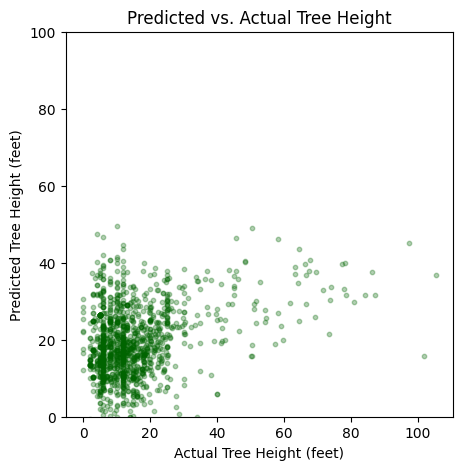

In [99]:
# Show (lack of) height correlation
X_train, X_val, y_train, y_val = single_tree_tts()
m = LinearRegression()
m.fit(X_train, y_train)
y_pred = m.predict(X_val)

plt.figure(figsize=(5, 5))
plt.scatter(y_val, y_pred, s=10, alpha=0.3, color='darkgreen')
plt.title('Predicted vs. Actual Tree Height')
plt.xlabel('Actual Tree Height (feet)')
plt.ylabel('Predicted Tree Height (feet)')
plt.ylim(0,100)

(0.0, 50.0)

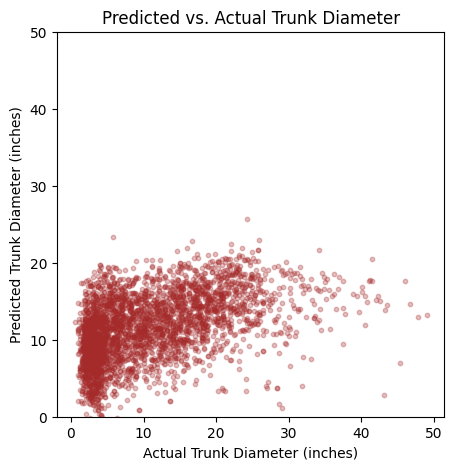

In [96]:
# Show (lack of) DHB correlation
X_train, X_val, y_train, y_val = single_tree_tts(y_metric='DBH')
m = LinearRegression()
m.fit(X_train, y_train)
y_pred = m.predict(X_val)

plt.figure(figsize=(5, 5))
plt.scatter(y_val, y_pred, s=10, alpha=0.3, color='brown')
plt.title('Predicted vs. Actual Trunk Diameter')
plt.xlabel('Actual Trunk Diameter (inches)')
plt.ylabel('Predicted Trunk Diameter (inches)')
plt.ylim(0,50)

### Classification models

Logistic Regression Accuracy: 0.7300
              precision    recall  f1-score   support

           1       0.35      0.21      0.27       999
           2       0.79      0.88      0.83      3364

    accuracy                           0.73      4363
   macro avg       0.57      0.55      0.55      4363
weighted avg       0.69      0.73      0.70      4363



Text(0.5, 1.0, 'Logistic Regression Performance On \n Coniferious vs. Broadleaf Trees')

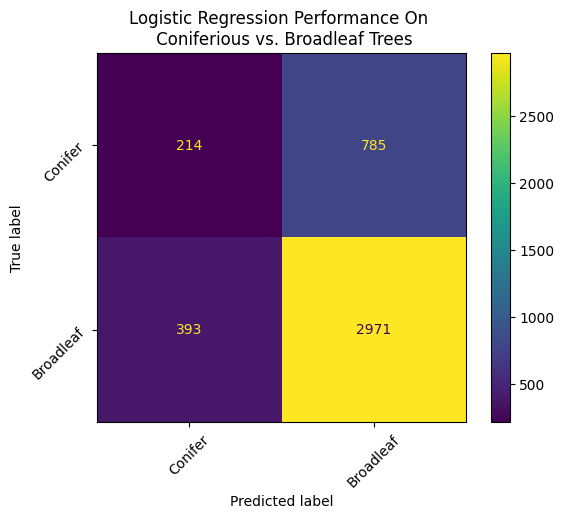

In [158]:
### Conifer vs. Broadleaf
## Logistic Regression
X_train, X_val, y_train, y_val = single_tree_tts(y_metric='CONIFER_CAT')

# Instantiate the model
logistic_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logistic_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = logistic_reg.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(classification_report(y_val, y_pred))
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Conifer', 'Broadleaf'])

disp.plot()
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=45)  # Rotate y-axis labels
plt.title("Logistic Regression Performance On \n Coniferious vs. Broadleaf Trees")

In [113]:
logistic_reg.classes_

array([1, 2])

Logistic Regression Accuracy: 0.7697
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       999
           2       0.77      1.00      0.87      3364

    accuracy                           0.77      4363
   macro avg       0.39      0.50      0.43      4363
weighted avg       0.59      0.77      0.67      4363



Text(0.5, 1.0, 'Logistic Regression Performance On \n Randomized Coniferious vs. Broadleaf Trees')

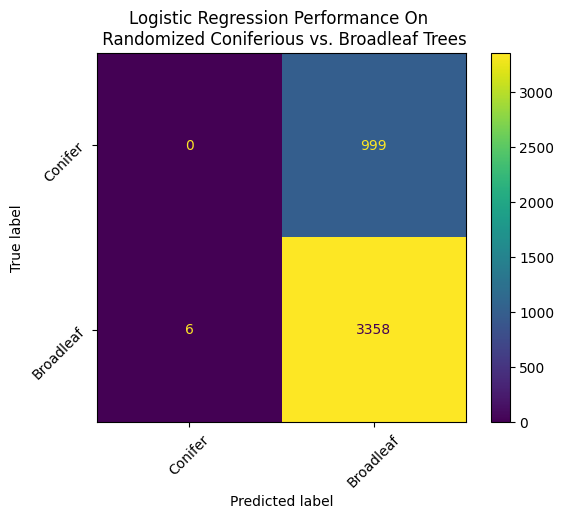

In [155]:
### Conifer vs. Broadleaf: random edition
## Logistic Regression
X_train, X_val, y_train, y_val = single_tree_tts(y_metric='CONIFER_CAT')

shuffler = np.random.default_rng(42)
y_train_random = y_train.copy()
shuffler.shuffle(y_train_random)
y_val_random = y_val.copy()
shuffler.shuffle(y_val_random)

# Instantiate the model
logistic_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logistic_reg.fit(X_train, y_train_random)

# Predict on the test set
y_pred = logistic_reg.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val_random, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(classification_report(y_val_random, y_pred))
cm = confusion_matrix(y_val_random, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Conifer', 'Broadleaf'])

disp.plot()
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=45)  # Rotate y-axis labels
plt.title("Logistic Regression Performance On \n Randomized Coniferious vs. Broadleaf Trees")

In [138]:
### Top genera classification
X_train, X_val, y_train, y_val = single_tree_tts(y_metric='GENUS_CAT')

# logistic regression
logistic_reg = LogisticRegression(max_iter=10000, random_state=42)

# Train the model
logistic_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = logistic_reg.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(classification_report(y_val, y_pred))
cm3 = confusion_matrix(y_val, y_pred)

Logistic Regression Accuracy: 0.3319
              precision    recall  f1-score   support

           1       0.13      0.18      0.15       438
           2       0.33      0.21      0.26       712
           3       0.28      0.10      0.15       476
           4       0.14      0.04      0.06       327
           5       0.09      0.02      0.03       152
           6       0.16      0.10      0.12       187
           7       0.43      0.02      0.04       147
           8       0.36      0.04      0.08       207
           9       0.06      0.01      0.02        85
          10       0.00      0.00      0.00        43
          11       0.40      0.71      0.51      1589

    accuracy                           0.33      4363
   macro avg       0.22      0.13      0.13      4363
weighted avg       0.29      0.33      0.27      4363



/home/eleanor/Documents/MADS/699_Capstone/tree-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [139]:
genera = list(genus_codes.keys())
genera.append('OTHER')

Text(0.5, 1.0, 'Logistic Regression Performance\n On Top 10 Tree Genera')

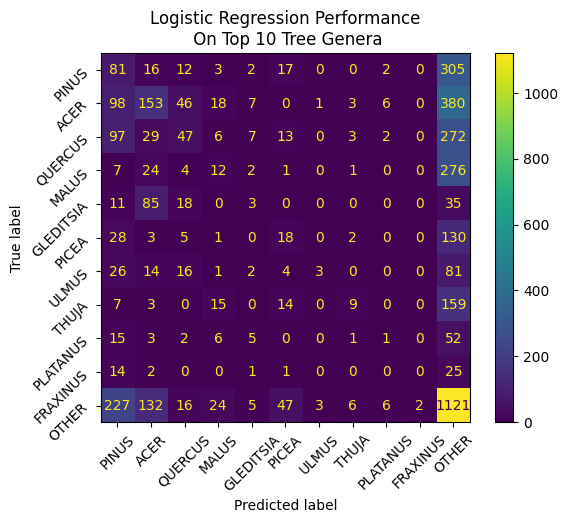

In [149]:
genus_codes
disp = ConfusionMatrixDisplay(confusion_matrix=cm3,
                              display_labels=genera)

disp.plot()
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=45)  # Rotate y-axis labels
plt.title("Logistic Regression Performance\n On Top 10 Tree Genera")

In [141]:
### Top genera classification: random edition!!
X_train, X_val, y_train, y_val = single_tree_tts(y_metric='GENUS_CAT')

shuffler = np.random.default_rng(42)
y_train_random = y_train.copy()
shuffler.shuffle(y_train_random)
y_val_random = y_val.copy()
shuffler.shuffle(y_val_random)

# logistic regression
logistic_reg = LogisticRegression(max_iter=10000, random_state=42)

# Train the model
logistic_reg.fit(X_train, y_train_random)

# Predict on the test set
y_pred = logistic_reg.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val_random, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(classification_report(y_val_random, y_pred))
cm4 = confusion_matrix(y_val_random, y_pred)

Logistic Regression Accuracy: 0.3571
              precision    recall  f1-score   support

           1       0.05      0.01      0.02       438
           2       0.00      0.00      0.00       712
           3       0.20      0.00      0.00       476
           4       0.00      0.00      0.00       327
           5       0.00      0.00      0.00       152
           6       0.00      0.00      0.00       187
           7       0.00      0.00      0.00       147
           8       0.00      0.00      0.00       207
           9       0.00      0.00      0.00        85
          10       0.00      0.00      0.00        43
          11       0.37      0.98      0.53      1589

    accuracy                           0.36      4363
   macro avg       0.06      0.09      0.05      4363
weighted avg       0.16      0.36      0.20      4363



/home/eleanor/Documents/MADS/699_Capstone/tree-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/eleanor/Documents/MADS/699_Capstone/tree-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eleanor/Documents/MADS/699_Capstone/tree-env/lib/python3.9/site-packages/sklearn/metrics

Text(0.5, 1.0, 'Logistic Regression Performance\n Using Randomized Labels')

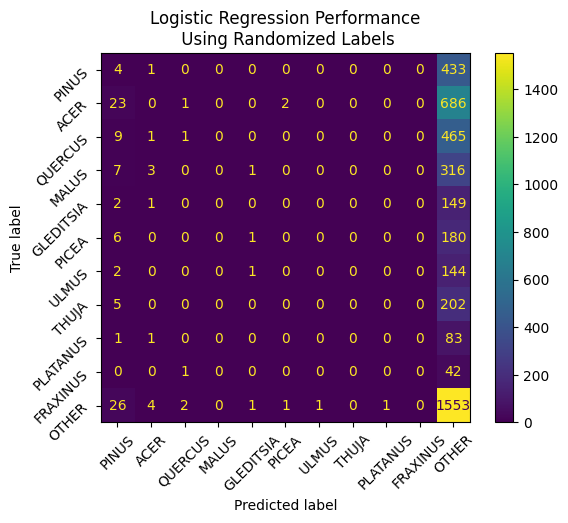

In [147]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm4,
                              display_labels=genera)
disp.plot()
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=45)  # Rotate y-axis labels
plt.title("Logistic Regression Performance\n Using Randomized Labels")